<center><h1 style="font-size:40px;">Exercise II:<br> Multi-layer perceptrons
for classification and regression problems.
</h1></center>

---

# Introduction

Welcome to the second lab in the Deep learning course! In this lab we will continue to take a look at four parts for MLP classification;
* Introduction for setup and train an MLP
* Impact of overfitting in validation performance 
* Avoid overfitting for a regression problem
* Model selection for classification



The lab includes different datasets, binary and multiple classification problems, and function approximation problems. 
The first part of the lab uses three different synthetic classification problems. They are all 2D binary classification problems that allow for easy visual inspection of the other classes and the network decision boundary. The datasets are defined as *syn1, syn2*, and *syn3*. These datasets are generated "on the fly" each time and are sampled from normal distributions. Note that as the data is sampled from a distribution, the data will vary for each time the data is generated it will be slightly different.

All tasks include **TODO's** these are expected to be done before the deadline for this lab. The labs also include **Question**, which should be answered and included in the report. The lab gives a hand to ensure correct answer with a few asserts or the expected results. Some sections do not contain any **TODO's** but are good to understand.

Good luck!

---

The following code allows us to edit imported files without restarting the kernel for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

# Hacky solution to access the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

from config import LabConfig
from dataset import MLPData
from DL_labs.utils.model import Model
from DL_labs.utils.progressbar import LitProgressBar
from DL_labs.utils.model import Model
from torch.utils.data import TensorDataset, DataLoader
from DL_labs.utils import (
    plot,
    progressbar
) 

/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [3]:
cfg = LabConfig()

## Plotting the data
To get an idea of the datasets for this lab. Below plots with 100 sample points are generated for syn1-syn3 and the spiral dataset.

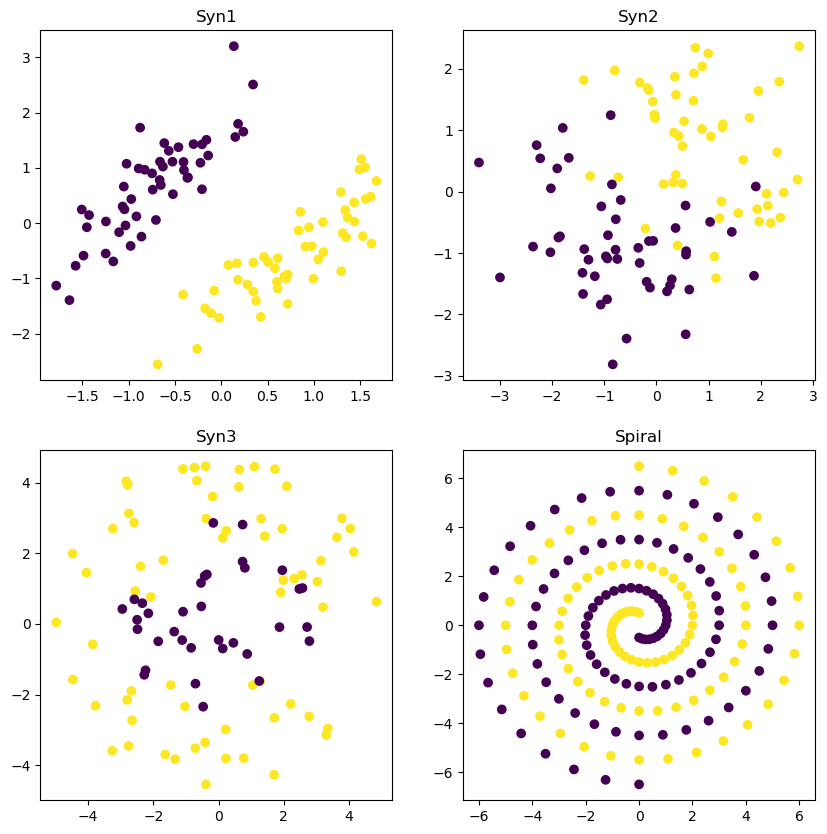

In [4]:
plot.data_distribution({
    "Syn1":MLPData.syn1(100),
    "Syn2":MLPData.syn2(100),
    "Syn3":MLPData.syn3(100),
    "Spiral":MLPData.spiral(cfg.spiral_path)
})

# Defining the MLP model

This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.


In [5]:
class MLP(torch.nn.Module):
    def __init__(self, 
                inp_dim=None,         
                hidden_nodes=1,                      # number of nodes in hidden layer
                num_out=None,
                **kwargs
            ):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(inp_dim, hidden_nodes)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_nodes, num_out)


    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return torch.sigmoid(output)

## Define a function that allow us to convert numpy to pytorch DataLoader

In [6]:
def numpy2Dataloader(x,y, batch_size=25, num_workers=10,**kwargs):
    return DataLoader(
        TensorDataset(
            torch.from_numpy(x).float(), 
            torch.from_numpy(y).unsqueeze(1).float()
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        **kwargs
    )

# Excercise 1
The cell below should be used for question 1. Looking at the code will help you understand how the network is created, trained and evaluated. It will be useful for the other questions.

**TODO:** Use syn1 with 100 data points and train a linear MLP to separate the two classes, i.e. use a single hidden node. What happened? Can the problem be solved with a single hidden node?

## Dataset

First we convert our dataset into a pytorch Dataset. Thereafter we load it into our DataLoader. Note that we here define the batch_size and the number of workers that should be used. 

In [7]:
x,y = MLPData.syn1(10000)
train_loader = numpy2Dataloader(x,y)

## Configuration
Setup our local config that should be used for the trainer.

In [8]:
config = {
    'max_epochs':4,
    'model_params':{
        'inp_dim':x.shape[1],         
        'hidden_nodes':1,   # activation functions for the hidden layer
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'criterion':torch.nn.BCELoss(), # error function
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    }
}

## Training

Lastly, put everything together and call on the trainers fit method. 

In [9]:
model = Model(MLP(**config["model_params"]),**config)

trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
trainer.fit(
    model, 
    train_dataloader=train_loader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Evaluation

In [10]:
plot.decision_bondary(trainer.get_model(), x,y) # To be fixed!

/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/trainer/deprecated_api.py:143: LightningDeprecationWarning: The use of `Trainer.get_model()` is deprecated in favor of `Trainer.lightning_module` and will be removed in v1.4.
  rank_zero_deprecation(
/home/stud1/f/fremar16/DL_labs/utils/plot.py:70: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)


In [11]:
#metrics.stats_class()
plot.stats_class(x, y, 'Training', trainer.get_model())


 ########## STATISTICS for Training Data ########## 

Accuracy   0.5
Sensitivity   0.0
Specificity   1.0
Loss   Not implemented

 ##################################################
